# Réduction de dimension

In [1]:
from pickleshare import PickleShareDB
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Chargement des données

Nous chargeons les données depuis le fichier des données préparées.

In [2]:
db = PickleShareDB('../prep_data/kity')

In [3]:
# Données nettoyées
# df_net_1 = db['net_attack_1_clean']
# df_net_2 = db['net_attack_2_clean']
# df_net_3 = db['net_attack_3_clean']
# df_net_4 = db['net_attack_4_clean']
# df_net_norm = db['net_norm_clean']

In [4]:
# Création d'un dataset avec toutes les données
#df = [db['net_attack_1_clean'], db['net_attack_2_clean'], db['net_attack_3_clean'], db['net_attack_4_clean'], db['net_norm_clean']]
#df = pd.concat(df, axis=0, ignore_index=True)

In [5]:
# Création d'un dataset avec toutes les données mixtes
df = [db['net_attack_1_clean'], db['net_attack_2_clean'], db['net_attack_3_clean'], db['net_attack_4_clean']]
df = pd.concat(df, axis=0, ignore_index=True)

In [6]:
# df = df_net_3.copy()

In [7]:
df = df.groupby('label', group_keys=False).apply(
    lambda x: x.sample(frac=0.25, random_state=42)
)

C:\Users\charl\AppData\Local\Temp\ipykernel_17808\2042881810.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('label', group_keys=False).apply(


In [8]:
df.head()

,Time,mac_s,mac_d,ip_s,ip_d,sport,dport,proto,flags,size,modbus_fn,n_pkt_src,n_pkt_dst,modbus_response,label_n,label,is_duplicate
21526548,2022-02-21 15:13:40.050878,74:46:a0:bd:a7:1b,fa:00:bc:90:d7:fa,84.3.251.20,84.3.251.103,dynamic/private_ports,system_ports,Modbus,11000,66,Read Holding Registers,56,13,inconnue,True,DoS,False
13106703,2021-04-09 19:55:36.762443,00:0c:29:47:8c:22,00:80:f4:03:fb:12,84.3.251.110,84.3.251.18,inconnu,inconnu,IP,inconnue,1514,inconnue,100,100,inconnue,True,DoS,False
17889198,2022-02-21 14:52:57.283072,00:0c:29:47:8c:0e,00:80:f4:03:fb:12,84.3.251.103,84.3.251.18,inconnu,inconnu,ICMP,inconnue,60,inconnue,90,88,inconnue,True,DoS,False
18693138,2022-02-21 14:57:33.730042,00:0c:29:47:8c:0e,00:80:f4:03:fb:12,84.3.251.20,84.3.251.18,inconnu,inconnu,ICMP,inconnue,60,inconnue,97,94,inconnue,True,DoS,False
11368320,2021-04-09 19:46:17.851341,00:0c:29:47:8c:22,74:46:a0:bd:a7:1b,84.3.251.20,84.3.251.20,inconnu,inconnu,ICMP,inconnue,60,inconnue,87,87,inconnue,True,DoS,False


In [9]:
print(f"{df[['label', 'label_n']].value_counts()}")

label           label_n
normal          False      3174002
DoS             True       1290386
MITM            True        538852
physical fault  True        387126
anomaly         True            97
scan            True            15
Name: count, dtype: int64


## Préparation des données

Avant de réaliser la PCA, nous préparons les données afin qu'elles soient traitées correctement lors de la réduction de dimensions.

La colonne Time, au format datetime, n'étant pas directement interprétable par la PCA, nous la supprimons.

Nous avions initialement généré des colonnes dérivées de Time telles que le jour, le mois, l'année, l'heure, la minute, la seconde, la microseconde et le delta de temps. Cependant, cette approche n'a pas donné de résultats pertinents : la PCA révélait principalement un alignement des points en fonction de la dimension temporelle, ce qui ne contribuait pas à l'analyse globale.

In [10]:
df = df.drop(columns=['Time'])

Nous normalisons les colonnes au format numérique afin qu'elles contribuent équitablement à la PCA et évitent qu'une variable domine les résultats.

In [11]:
scaler = StandardScaler()
df[['n_pkt_src', 'n_pkt_dst', 'size']] = scaler.fit_transform(df[['n_pkt_src', 'n_pkt_dst', 'size']])

Nous supprimons les colonnes label et label_n pour éviter qu'elles influencent la PCA, car ce sont les variables cibles et non pas des caractéristiques.  
Mais nous les conservons pour pouvoir les rajouter plus tard dans l'analyse et la visualisation.

In [12]:
labels = df[['label', 'label_n']]
df = df.drop(columns=['label', 'label_n'])

Pour les colonnes catégorielles avec peu de valeurs différentes, nous avons réalisé un One-Hot afin de transformer leurs catégories en variables binaires.  
Cela permet à la PCA de traiter correctement ces colonnes non numériques, en concervant les valeurs des catégories.

In [13]:
df = pd.get_dummies(df, columns=['flags',  'proto', 'modbus_fn', 'modbus_response', 'dport', 'sport',], prefix=['flags', 'proto', 'modbus_fn', 'modbus_response', 'dport', 'sport',])

Pour les colonnes de type object, nous avons appliqué un encodage ordinal pour convertir les catégories en valeurs numériques, afin qu'elles soient exploitables dans la PCA.
Puis nous les standardisons pour qu'elles aient le même poids que les autres colonnes numériques.

In [14]:
ordinal_encoder = OrdinalEncoder()
df[['ip_s', 'ip_d', 'mac_s', 'mac_d']] = ordinal_encoder.fit_transform(df[['ip_s', 'ip_d', 'mac_s', 'mac_d']])
scaler = StandardScaler()
df[['ip_s', 'ip_d', 'mac_s', 'mac_d']] = scaler.fit_transform(df[['ip_s', 'ip_d', 'mac_s', 'mac_d']])

Nous supprimons les colonnes créée à cause des valeurs manquantes, car elles n'ont pas d'utilitées.

In [15]:
df.drop(columns=['modbus_fn_inconnue', 'flags_inconnue',  'modbus_response_inconnue'], inplace=True) #'sport_inconnu', 'dport_inconnu',

Nous transformons les valeurs booléennes en float afin qu'elles soient traitées correctement dans la PCA.

In [16]:
for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(float)

### Vérification

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5390478 entries, 21526548 to 20504081
Data columns (total 53 columns):
 #   Column                                     Dtype  
---  ------                                     -----  
 0   mac_s                                      float64
 1   mac_d                                      float64
 2   ip_s                                       float64
 3   ip_d                                       float64
 4   size                                       float64
 5   n_pkt_src                                  float64
 6   n_pkt_dst                                  float64
 7   is_duplicate                               float64
 8   flags_0                                    float64
 9   flags_1                                    float64
 10  flags_10                                   float64
 11  flags_100                                  float64
 12  flags_10000                                float64
 13  flags_10001                            

Notre dataset ne contient plus que des colonnes numériques exploitables par la PCA.

In [18]:
df.head()

,mac_s,mac_d,ip_s,ip_d,size,n_pkt_src,n_pkt_dst,is_duplicate,flags_0,flags_1,...,modbus_response_8,modbus_response_autre,dport_dynamic/private_ports,dport_inconnu,dport_system_ports,dport_user_ports,sport_dynamic/private_ports,sport_inconnu,sport_system_ports,sport_user_ports
21526548,0.419917,1.525927,0.93772,-0.923987,-0.381051,0.393781,-0.993477,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
13106703,-1.463016,-1.401569,0.21750,0.516950,2.613531,1.819883,1.870304,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
17889198,-1.933749,-1.401569,-0.86283,0.516950,-0.393459,1.495769,1.475300,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
18693138,-1.933749,-1.401569,0.93772,0.516950,-0.393459,1.722649,1.672802,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
11368320,-1.463016,0.354929,0.93772,0.877184,-0.393459,1.398535,1.442383,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


## Réduction de dimensions : PCA

### Variance expliquée par les dimensions

In [ ]:
pca = PCA()
df_pca = pca.fit(df)

In [20]:
variance_expliquee = (pca.explained_variance_ratio_ * 100).round(2)
#variance_expliquee = variance_expliquee.round(2)

variance_table = pd.DataFrame({
    "Composante": [f"PC{i+1}" for i in range(len(variance_expliquee))],
    "Pourcentage de Variance Expliquée": variance_expliquee,
    "Total": variance_expliquee.cumsum()
})

print(variance_table)

   Composante  Pourcentage de Variance Expliquée  Total
0         PC1                              43.73  43.73
1         PC2                              31.87  75.60
2         PC3                               5.50  81.10
3         PC4                               5.08  86.18
4         PC5                               2.79  88.97
5         PC6                               2.09  91.06
6         PC7                               1.87  92.93
7         PC8                               1.60  94.53
8         PC9                               1.19  95.72
9        PC10                               1.03  96.75
10       PC11                               0.89  97.64
11       PC12                               0.81  98.45
12       PC13                               0.38  98.83
13       PC14                               0.23  99.06
14       PC15                               0.18  99.24
15       PC16                               0.17  99.41
16       PC17                               0.15

Le nombre de dimensions minimum permettant de conserver au moins 90% de l'information :
- df_1 : 6 dimensions (PC6  2.65  91.94)
- df_2 : 6 dimensions (PC6  2.26  91.29)
- df_3 : 4 dimensions (PC4  2.33  91.95)
- df_4 : 6 dimensions (PC6  2.62  90.53)
- df_norm : pas d'interêt
- all : 6 dimensions (PC6  2.22  91.00)
- all - df_norm : 6 dimensions (PC6 2.09  91.06)

In [21]:
db['pca_variance_table'] = variance_table

### Features importants par dimensions

In [22]:
# Poids features par dimension
pca_components = pd.DataFrame(pca.components_, columns=df.columns, index=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))])

print("Contribution des features à chaque composante principale :")
print(pca_components)

Contribution des features à chaque composante principale :
             mac_s         mac_d          ip_s          ip_d          size  \
PC1  -4.042411e-01 -3.681370e-01  5.241479e-02  1.600204e-01  3.986755e-01   
PC2   4.498669e-02  4.456111e-03 -5.229013e-01  4.988415e-01 -1.837702e-02   
PC3  -2.550047e-01 -5.947224e-01  9.543880e-02  1.622255e-01 -6.469488e-01   
PC4  -5.908584e-01  6.432476e-01  1.479907e-01 -9.814944e-03 -3.092781e-01   
PC5  -2.261174e-01 -1.256491e-01  2.785120e-01  9.063289e-02  3.202529e-01   
PC6  -4.134841e-01 -1.823092e-01 -4.274909e-01 -4.670117e-01  1.280896e-01   
PC7  -3.535686e-01  7.080151e-02  1.366034e-01  1.042269e-01  1.696903e-01   
PC8   5.700955e-02  1.145029e-01 -4.471804e-01 -2.392145e-01 -3.650431e-02   
PC9   1.207934e-01  6.075302e-02  2.219143e-01  1.564724e-01  4.948098e-02   
PC10  4.769658e-02  7.212066e-02 -1.149659e-02  1.947794e-01  1.865953e-02   
PC11 -1.913368e-01  1.287077e-01 -3.383842e-01  5.278570e-01  6.030530e-02   
PC12 

In [23]:
# Affichage des features les plus importants pour chaque composante
pca_components = pd.DataFrame(pca.components_, columns=df.columns, index=[f'PC{i+1}' for i in range(len(pca.components_))])

top_features = {}
for pc in ['PC1', 'PC2', 'PC3']:
    top_features[pc] = pca_components.loc[pc].abs().nlargest(5).index.tolist()

for pc, features in top_features.items():
    print(f"{pc} : {', '.join(features)}")

PC1 : n_pkt_dst, mac_s, size, n_pkt_src, mac_d
PC2 : ip_s, ip_d, n_pkt_src, dport_dynamic/private_ports, sport_system_ports
PC3 : size, mac_d, mac_s, proto_IP, ip_d


### Visualisation des résultats

#### 2 premières dimensions de la PCA

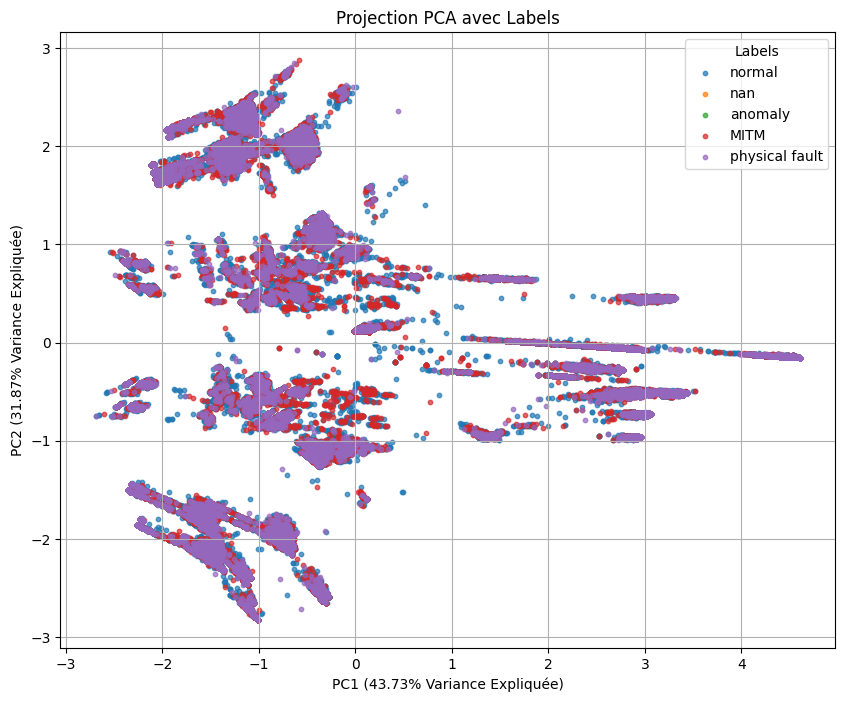

In [24]:
pca = PCA(n_components=2)
df_pca_2d = pca.fit_transform(df)

df_pca_with_labels = pd.DataFrame(df_pca_2d, columns=["PC1", "PC2"])
df_pca_with_labels["label"] = labels["label"] # ajout des labels

plt.figure(figsize=(10, 8))
for label in df_pca_with_labels["label"].unique():
    subset = df_pca_with_labels[df_pca_with_labels["label"] == label]
    plt.scatter(subset["PC1"], subset["PC2"], label=label, alpha=0.7, s=10)
plt.xlabel("PC1 (%.2f%% Variance Expliquée)" % (pca.explained_variance_ratio_[0] * 100))
plt.ylabel("PC2 (%.2f%% Variance Expliquée)" % (pca.explained_variance_ratio_[1] * 100))
plt.title("Projection PCA avec Labels")
plt.legend(title="Labels", loc="best")
plt.grid(True)
plt.show()

#### 3 premières dimensions de la PCA

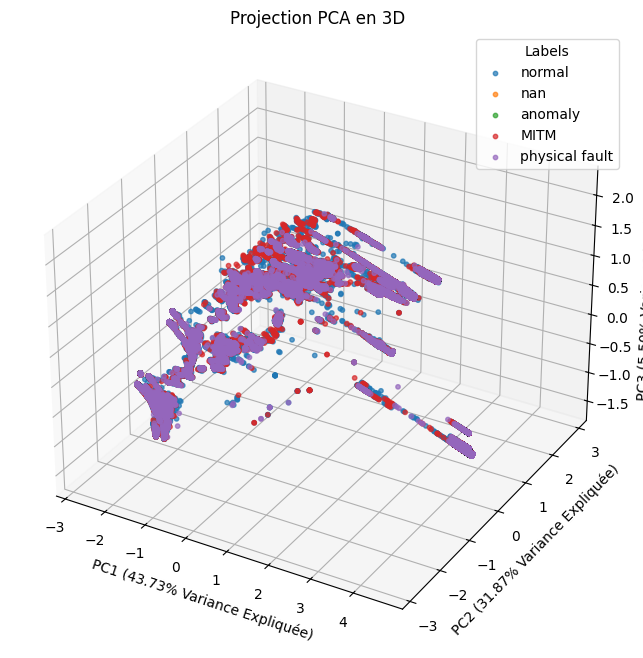

In [25]:
pca = PCA(n_components=3)
df_pca_3d = pca.fit_transform(df)

df_pca_with_labels = pd.DataFrame(df_pca_3d, columns=["PC1", "PC2", "PC3"])
df_pca_with_labels["label"] = labels["label"]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label in df_pca_with_labels["label"].unique():
    subset = df_pca_with_labels[df_pca_with_labels["label"] == label]
    ax.scatter(subset["PC1"], subset["PC2"], subset["PC3"], label=label, alpha=0.7, s=10)

ax.set_xlabel("PC1 (%.2f%% Variance Expliquée)" % (pca.explained_variance_ratio_[0] * 100))
ax.set_ylabel("PC2 (%.2f%% Variance Expliquée)" % (pca.explained_variance_ratio_[1] * 100))
ax.set_zlabel("PC3 (%.2f%% Variance Expliquée)" % (pca.explained_variance_ratio_[2] * 100))
ax.set_title("Projection PCA en 3D")
ax.legend(title="Labels", loc="best")
plt.show()

La réduction de dimension par PCA permet de réduire le nombre de colonnes dans les datasets tout en concervant une grande partie de l'information.  
Nous allons utiliser ces résultats dans nos modèles afin de réduire la taille des données tout en gardant un maximum d'information.

## Enregistrement données

In [26]:
# Calcul de la PCA et transformation en df
pca = PCA(n_components=6)
df_pca = pca.fit_transform(df)

df_pca_result = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(df_pca.shape[1])])

In [27]:
# Enregistrement sans les labels
db['pca_result_no_label'] = df_pca_result

In [28]:
print(df_pca_result.head())

        PC1       PC2       PC3       PC4       PC5       PC6
0 -1.482298 -1.937727 -0.743719  0.699006 -0.240442 -0.167831
1  4.588479 -0.150993 -0.946828 -0.384186  0.182047  0.017670
2  3.153834  0.452036  1.441078  0.810323 -1.095553  0.315626
3  3.416999 -0.509362  1.579766  1.118728 -0.704821 -0.557227
4  2.417901 -0.259762  0.515516  1.916760 -0.850770 -1.103534


In [29]:
# Enregistrement avec les labels
df_pca_result_with_labels = pd.concat([df_pca_result, labels.reset_index(drop=True)], axis=1)
db['pca_result_with_labels'] = df_pca_result_with_labels

In [30]:
print(df_pca_result_with_labels.head())

        PC1       PC2       PC3       PC4       PC5       PC6 label  label_n
0 -1.482298 -1.937727 -0.743719  0.699006 -0.240442 -0.167831   DoS     True
1  4.588479 -0.150993 -0.946828 -0.384186  0.182047  0.017670   DoS     True
2  3.153834  0.452036  1.441078  0.810323 -1.095553  0.315626   DoS     True
3  3.416999 -0.509362  1.579766  1.118728 -0.704821 -0.557227   DoS     True
4  2.417901 -0.259762  0.515516  1.916760 -0.850770 -1.103534   DoS     True
